In [1091]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix 
from random import sample

In [1092]:
df1=pd.read_csv(r'C:\Users\kacpr\OneDrive - Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie\Licencjat\Dane\otomoto_offers_eng_23-04-2023.csv',delimiter=';')

C:\Users\kacpr\AppData\Local\Temp\ipykernel_14660\3093558874.py:1: DtypeWarning: Columns (188,213,242) have mixed types. Specify dtype option on import or set low_memory=False.
  df1=pd.read_csv(r'C:\Users\kacpr\OneDrive - Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie\Licencjat\Dane\otomoto_offers_eng_23-04-2023.csv',delimiter=';')


# Transformacje

## usunięcie nadmiarowych kolumn

In [1093]:
df1.shape

(208205, 243)

Dane posiadają 208 tysięcy rekordów oraz 243 kolumny.

Na początku wybieram 30 pierwszych kolumn, gdyż tutaj znajdują się najważniejsze cechy. W pozostałych 170 kolumnach głownie znajdowały się informację o wyposażeniu samochodu (np. czy posiada radio TRUE/FALSE). Nie zagłębiam się tak dokładnie w predykcję cen, więc usuwam te kolumny i wybiorę tylko kilka najwazniejszych:

In [1094]:
df2=df1.iloc[:,0:30].copy()

In [1095]:
df2.columns

Index(['id', 'offer_creation_date', 'offer_title', 'price', 'currency',
       'seller_type', 'seller_registration_year', 'location', 'offer_from',
       'category', 'show_offers_with_vin_number', 'vehicle_brand',
       'vehicle_model', 'generation', 'production_year', 'mileage',
       'engine_displacement', 'fuel_type', 'power', 'transmission',
       'body_type', 'number_of_doors', 'number_of_seats', 'color',
       'vat_margin', 'financing_possibility', 'state', 'version',
       'fuel_consumption_in_city', 'color_type'],
      dtype='object')

Teraz zajmę się oczyszczaniem tych kolumn. Najpierw dodam kolumny, które będą mi potrzebne do oczyszczenia danych:

In [1096]:
df3= pd.concat([df2, df1[['drive_type','no_accident','damaged']]], axis=1)

Te kolumny usuwam, ponieważ są zbędne do naszego modelu. 

In [1097]:
df3=df3.drop(['id','vat_margin','offer_from','category','offer_creation_date','financing_possibility','offer_title','show_offers_with_vin_number','location','version', 'color','color_type','generation'],axis=1).copy()

wyrzucam offer_creation_year bo wszystkie dane są z tego samego miesiaca i offer_from bo to to samo co seller type tylko po polsku. Category to po prostu osobowe, wiec tą kolumne tez usuwam. Id bo bez sensu

## lista wybranych kolumn

In [1098]:
df3.columns

Index(['price', 'currency', 'seller_type', 'seller_registration_year',
       'vehicle_brand', 'vehicle_model', 'production_year', 'mileage',
       'engine_displacement', 'fuel_type', 'power', 'transmission',
       'body_type', 'number_of_doors', 'number_of_seats', 'state',
       'fuel_consumption_in_city', 'drive_type', 'no_accident', 'damaged'],
      dtype='object')

## Czyszczenie i edycja danych

1. Zmienna 'price' jest w różnych walutach. Zmienię ją na walute PLN

In [1099]:
df3['price'] = df3['price'].astype(float)
df3.loc[df3['currency'] == 'EUR', 'price'] *= 4.29
df3=df3.drop('currency',axis=1)

2. Nasze badanie opiera się na samochodach używanych, więc usunę wszystkie nowe samochodu. Cena nowego samochodu może zaburzać nasze modele.

In [1100]:
filt=(df3['state']=='New')
len(df3[filt])
df3 = df3.loc[~filt]
df3=df3.drop('state',axis=1)

20 690 samochodów w naszych danych jest oznaczone jako nowe. Usuwamy je z naszej bazy

3. usuwamy pojazdy oznaczone jako 'damaged'oraz 'no_accident'!='Tak', gdyż cieżko jest przewidywac cenę samochodów uszkodzonych

In [1101]:
filt=(df3['no_accident']=='Tak')
df3=df3.loc[~filt]

filt=(df3['damaged']=='Tak')
df3=df3.loc[~filt]
df3=df3.drop('no_accident',axis=1)
df3=df3.drop('damaged',axis=1)
len(df3)

79564

po usunięciu zbędnych wiersz zostaje nam 80 tysięcy rekordów

4. Usuwanie miar (moc,pojemnosc silnika,przebieg)

In [1102]:
df3['mileage'] = df3['mileage'].str.replace(' km','').str.replace(' ','').astype(float)
df3['engine_displacement'] = df3['engine_displacement'].str.replace(' cm3','').str.replace(' ','').astype(float)
df3['power'] = df3['power'].str.replace(' KM','').str.replace(' ','').astype(float)

5. zmiana kolumny production_year na liczbę wieku samochodu (przyjmuję 2023 jako rok, poniewaz dane są z tego roku)

In [1103]:
df3['car_age'] = df3['production_year'].apply(lambda x: 2023 - x)
df3=df3.drop('production_year',axis=1)

6. zmiana kolumny seller_registration_date na seller_experience (przyjmuje 2023)

In [1104]:
df3['seller_experience'] = df3['seller_registration_year'].apply(lambda x: 2023 - x)
df3=df3.drop('seller_registration_year',axis=1)

Odrazu też wyczyszczę kolumnę seller_experience ponieważ posiada one błędy - serwis OtoMoto powstał w 2004 roku(czyli 19 lat od 2023), a w danych znajduje sie 30 wartości które mają więcej niż 19 lat. Zamienie te wartości na średnią

In [1105]:
filt=df3['seller_experience']>19
df3.loc[filt,'seller_experience']=df3['seller_experience'].mean()

C:\Users\kacpr\AppData\Local\Temp\ipykernel_14660\3902503771.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.177416922226133' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df3.loc[filt,'seller_experience']=df3['seller_experience'].mean()


## Podsumowanie czyszczenia i transformacji danych

1. Pozbyłem się większości kolumn które zawierały informację czy samochód np. ma elektryczne szyby czy nie (TRUE/FALSE)
2. Pozbyłem się potem kolejnych kolumn, które wydawały się zbędnę np. kolor, lokalizacja
3. Zmieniłem wszystkie ceny na jedną walutę
4. Usunąłem z danych pojazdy oznaczone jako nowe
5. Usunąłem pojazdy oznaczone jako 'damaged' albo 'accident'
6. Wyczyściłem zmienne liczbowe z miar 
7. Stworzyłem kolumnę 'car_age'
8. Stworzyłem kolumnę seller_experience

# Sprawdzenie wartości brakujących i odstających

In [1106]:
df4=df3

In [1107]:
df4.columns

Index(['price', 'seller_type', 'vehicle_brand', 'vehicle_model', 'mileage',
       'engine_displacement', 'fuel_type', 'power', 'transmission',
       'body_type', 'number_of_doors', 'number_of_seats',
       'fuel_consumption_in_city', 'drive_type', 'car_age',
       'seller_experience'],
      dtype='object')

In [1190]:
df4.isnull().values.any()

np.False_

### Engine_displacement

In [1109]:
df4['engine_displacement'].isnull().sum()

np.int64(531)

In [1110]:
filt=(df4['fuel_type']=='Electric') | (df4['fuel_type']=='Hyrdrogen') 

In [1111]:
df4.loc[filt]

,price,seller_type,vehicle_brand,vehicle_model,mileage,engine_displacement,fuel_type,power,transmission,body_type,number_of_doors,number_of_seats,fuel_consumption_in_city,drive_type,car_age,seller_experience
26,73500.0,Private person,BMW,i3,32000.0,NaN,Electric,170.0,Automatic,Compact,5.0,4.0,NaN,Front wheels,9,0.0
456,184900.0,Private person,Tesla,Model S,206000.0,NaN,Electric,378.0,Automatic,Compact,5.0,5.0,NaN,NaN,8,9.0
588,64999.0,Private person,Renault,Twingo,6800.0,NaN,Electric,82.0,Automatic,Small cars,5.0,4.0,NaN,Front wheels,2,9.0
944,105900.0,Dealer,Nissan,Leaf,28908.0,NaN,Electric,150.0,Automatic,City cars,5.0,5.0,NaN,Front wheels,4,3.0
1008,50000.0,Private person,Nissan,Leaf,95000.0,NaN,Electric,109.0,Automatic,City cars,5.0,5.0,NaN,Front wheels,7,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205305,122600.0,Private person,Hyundai,Kona,44000.0,NaN,Electric,204.0,Automatic,SUV,5.0,5.0,NaN,NaN,2,5.0
205885,179900.0,Dealer,Tesla,Model 3,49500.0,NaN,Electric,512.0,Automatic,Sedan,4.0,5.0,NaN,4x4 (fixed),3,6.0
206734,184999.0,Dealer,Tesla,Model 3,69000.0,NaN,Electric,497.0,Automatic,Sedan,4.0,5.0,NaN,4x4 (fixed),3,3.0
207639,74900.0,Private person,Renault,Zoe,23200.0,NaN,Electric,109.0,Automatic,Compact,5.0,NaN,NaN,NaN,5,9.0


508 z 531 brakujących danych to samochody elektryczne które nie posiadają pojemności silnika, więc zamieniam wartości na 0

In [1112]:
df4.loc[filt,'engine_displacement']=0

resztę samochodów które miały braki uzupełniam średnią z kolumny engine displacement

In [1113]:
df4['engine_displacement'].isnull().sum()

np.int64(23)

In [1114]:
df4['engine_displacement'] = df4['engine_displacement'].fillna(df4['engine_displacement'].mean())

### Number of doors

In [1115]:
df4['number_of_doors'].isnull().sum()

np.int64(557)

liczba drzwi zostawiam i z racji ze liczba brakow jest mala to usuwam wiersze z brakami

In [1116]:
filt = df4['number_of_doors'].isnull()
df4 = df4.loc[~filt]

### Number of seats

In [1117]:
df4['number_of_seats'].isnull().sum()

np.int64(5971)

jest sporo braków więc tą kolumnę usuwam

In [1118]:
df4=df4.drop('number_of_seats',axis=1)

### Fuel consumption

In [1119]:
df4['fuel_consumption_in_city'].isnull().sum()

np.int64(30285)

niestety tutaj też musze usunąc kolumnę bo ponad połowa to braki

In [1120]:
df4=df4.drop('fuel_consumption_in_city',axis=1)

### Drive type

In [1121]:
df4['drive_type'].isnull().sum()

np.int64(20973)

tutaj też usuwam bo bardzo dużo braków

In [1122]:
df4=df4.drop('drive_type',axis=1)

In [1123]:
df4.isnull().values.any()

np.True_

In [1124]:
new_data = df4.dropna(axis=0, how='any')

In [1125]:
((len(df4)-len(new_data))/len(df4))*100

0.01645423823205539

Około 0.016 % danych miało jakieś wartości brakujące. Z uwagi na fakt, że jest to bardzo mała liczba to usuwam całe wiersze z danych

In [1126]:
df4=new_data.copy()

In [1127]:
len(df4)

78994

### Wartosci odstające

In [1128]:
filt=df4['price']>1500000
df4=df4.loc[~filt]

Pozbywam się aut powyżej 1500000 zł z racji że są to wartości odstające

In [1129]:
filt=df4['power']>800
df4=df4.loc[~filt]

Usuwam samochody >800 koni

In [1130]:
filt=df4['mileage']>1500000
df4=df4.loc[~filt]

Usuwam auta >1500000 km przebiegu

### Wybranie 10 najliczniejszych producentów

mamy 87 producentów samochodów, lecz w moim badaniu skupię się na 10 najliczniejszych

In [1131]:
list=df4['vehicle_brand'].value_counts().head(10).sort_values(ascending=False)

In [1132]:
filt=df4['vehicle_brand'].isin(list.index)

In [1133]:
df5=df4.loc[filt]

Wybieram od każdego producenta 3 najpopularniejsze modele samochodów

In [1134]:
len(df5)

51697

Zmiana na kategoryczne zmienne

In [1135]:
df4.columns

Index(['price', 'seller_type', 'vehicle_brand', 'vehicle_model', 'mileage',
       'engine_displacement', 'fuel_type', 'power', 'transmission',
       'body_type', 'number_of_doors', 'car_age', 'seller_experience'],
      dtype='object')

In [1136]:
categorical_columns = ['seller_type', 'vehicle_brand', 'fuel_type','vehicle_model', 'transmission', 'body_type','number_of_doors']
df5[categorical_columns] = df5[categorical_columns].astype('category')

C:\Users\kacpr\AppData\Local\Temp\ipykernel_14660\2553443733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5[categorical_columns] = df5[categorical_columns].astype('category')


## Podsumowanie usuwania braków i wartości odstających

1. Usunięta została kolumna 'engine_displacment' (pojemność silnika) z uwagi na fakt, że samochody elektryczne nie posiadają pojemności.
2. Usunięte zostały wiersze, w których znalazła się jakakolwiek kolumna z brakiem danych. Takich sytuacji było około 500, co stanowi 0.03% danych, które usuwamy
3. Podzieliłem dane na 2 warianty - w jednym na zmienną 'price' nałożyłem logarytm naturalny (co pomogło usunąć skośność rozkładu), a drugi zestaw danych pozostał bez zmian w kolumnie y
4. Następnie metodą IQR (poniżej Q25 kwartla i powyzej Q75 kwartla) zostały usunięte wartości w dwóch zestawach danych. W danych bez logarytmu usunięte zostało 5 tysięcy danych, a w danych z logarytmem 500 danych
5. Następnie wybrałem 15 najliczniejszych producentów (aby nie doszło do sytuacji, gdzie jakiś producent ma 1 auto w zestawie danych). 
6. Zmieniłem typ danych kategorycznych na 'category'

# EDA i korelacje

array([[<Axes: xlabel='price', ylabel='price'>,
        <Axes: xlabel='mileage', ylabel='price'>,
        <Axes: xlabel='engine_displacement', ylabel='price'>,
        <Axes: xlabel='power', ylabel='price'>,
        <Axes: xlabel='car_age', ylabel='price'>,
        <Axes: xlabel='seller_experience', ylabel='price'>],
       [<Axes: xlabel='price', ylabel='mileage'>,
        <Axes: xlabel='mileage', ylabel='mileage'>,
        <Axes: xlabel='engine_displacement', ylabel='mileage'>,
        <Axes: xlabel='power', ylabel='mileage'>,
        <Axes: xlabel='car_age', ylabel='mileage'>,
        <Axes: xlabel='seller_experience', ylabel='mileage'>],
       [<Axes: xlabel='price', ylabel='engine_displacement'>,
        <Axes: xlabel='mileage', ylabel='engine_displacement'>,
        <Axes: xlabel='engine_displacement', ylabel='engine_displacement'>,
        <Axes: xlabel='power', ylabel='engine_displacement'>,
        <Axes: xlabel='car_age', ylabel='engine_displacement'>,
        <Axes: xlabel=

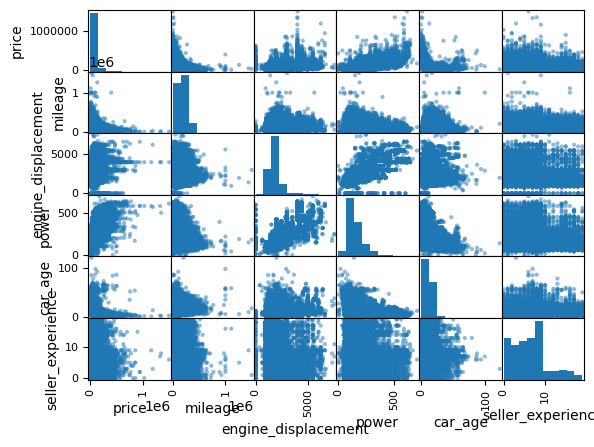

In [1137]:
scatter_matrix(df5)

Text(0.5, 1.0, 'Liczność producenta samochodów')

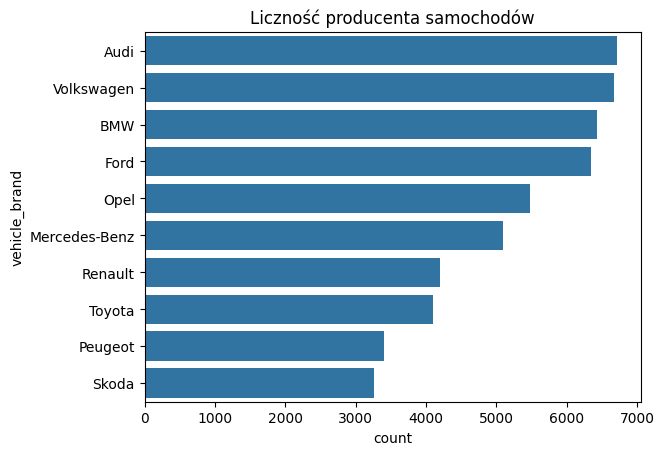

In [1138]:
plt.figure()
sns.countplot(y=df5['vehicle_brand'],order=list.index)
plt.title('Liczność producenta samochodów')

## Czy cena zależy od marki auta?

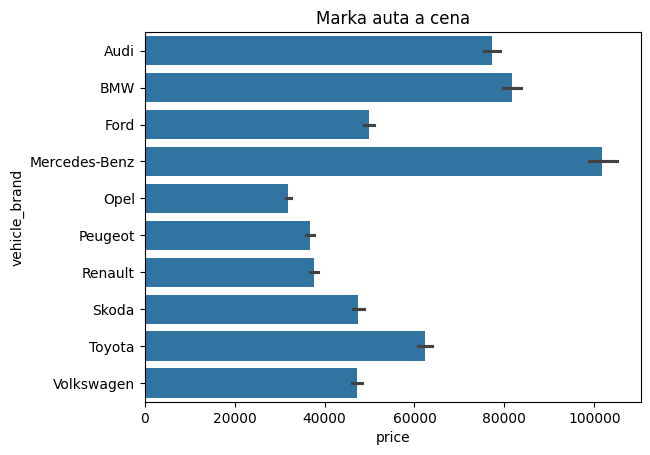

In [1139]:
plt.figure()
sns.barplot(x=df5['price'], y=df5['vehicle_brand'], orient='h')
plt.title('Marka auta a cena')
plt.show()

Najdroższymi markami są: Volvo, Audi, BMW i Mercedes-Benz, czyli samochody klasy 'premium'. Najtańsze marki to Opel i Renault.

## Typ paliwa

In [1140]:
df5['fuel_type'].value_counts()

fuel_type
Diesel            25153
Gasoline          22930
Gasoline + LPG     2008
Hybrid             1369
Electric            203
Gasoline + CNG       33
Hydrogen              1
Name: count, dtype: int64

z racji że w danych znajduje się tylko jeden samochód o napędzie wodorowym to pozbędziemy się go 

In [1141]:
filt=(df5['fuel_type']=='Hydrogen')
df5=df5.loc[~filt]

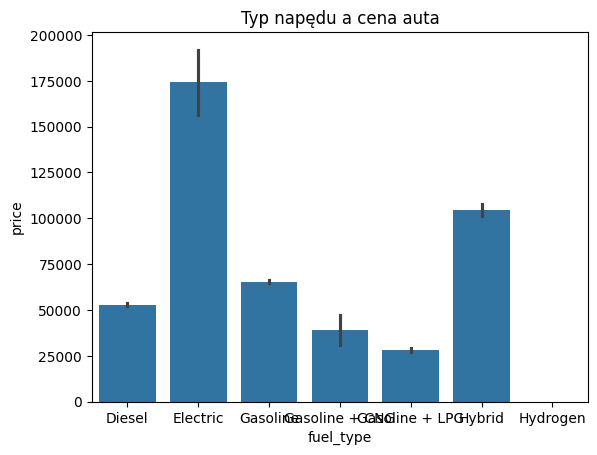

In [1142]:
plt.figure()
sns.barplot(x=df5['fuel_type'],y=df5['price'])
plt.title('Typ napędu a cena auta')
plt.show()

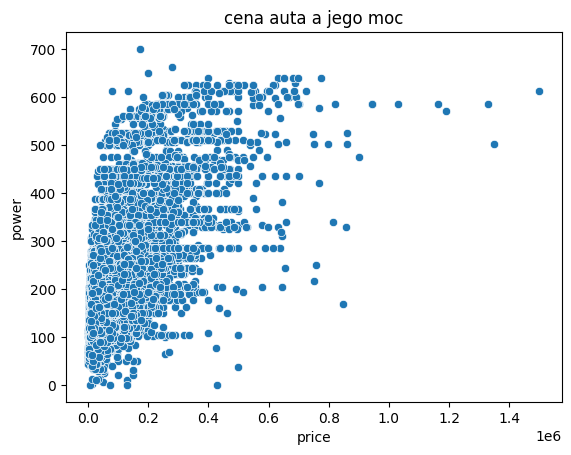

In [1143]:
plt.figure()
sns.scatterplot(x=df5['price'],y=df5['power'])
plt.title('cena auta a jego moc')
plt.show()

## Macierze korelacji

Usuwam z macierzy kolumnę vehicle_model, gdyż po analizie korelacji raczej inne cechy są dominujące a model samochodu nie ma wielkiego wpływu na cenę (bardziej marka, dlatego markę zostawiam w badaniu)

Tak prezentuje się macierz korelacji zmiennych. Jeśli chodzi o zmienną price to najsilniejsze korelacje widzimy ze zmiennymi: car_age,milage,power,body_type

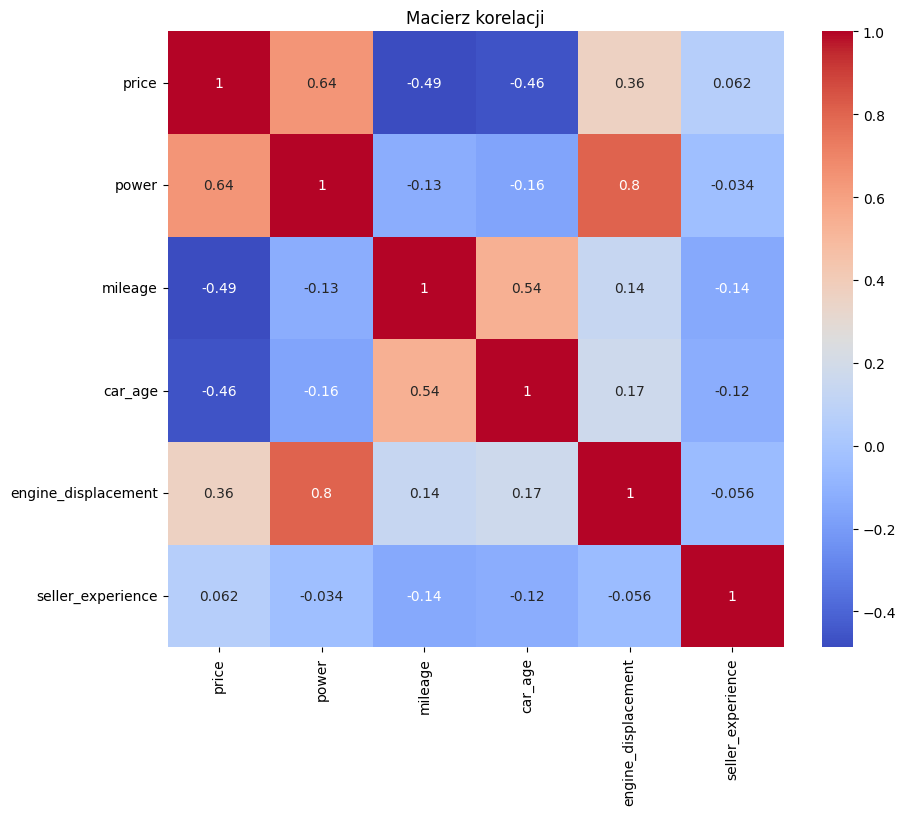

In [1144]:
plt.figure(figsize=(10, 8))
sns.heatmap(df5[['price', 'power', 'mileage', 'car_age','engine_displacement','seller_experience']].corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Macierz korelacji')
plt.show()

## Podsumowanie rozdziału EDA i korelacje

1. Na początku przedstawiłem kilka wykresów. Będzie ich więcej w późniejszym etapie.
2. Okazało się, że w naszych danych jest tylko jedno auto na wodór, więc je usuwam
3. Przeprowadzona analiza korelacji - usunięcie kolumny model auta, gdyż jest to zbytnie zagłebianie się w szczegóły a korelacje nie są znaczące

# Skalowanie cech numerycznych

Z racji, że nasze zmienne są w różnej skali to przeskaluje je poprzez standard scaler (x-u)/s

In [1181]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
numeric_features = ['power', 'mileage', 'car_age','engine_displacement','seller_experience']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['seller_type', 'vehicle_brand', 'fuel_type','vehicle_model', 'transmission', 'body_type','number_of_doors']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Regresja liniowa

In [1182]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regg', LinearRegression())])

y = df5['price']
X = df5.drop('price', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)


Wynik regresji liniowej:

In [1187]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))


model score: 0.756


Wynik regresji liniowej (MAE):

In [1058]:
y_pred=clf.predict(X_test)
mean_absolute_error(y_pred,y_test)

21294.896116795335

### Z logarytmem na y

In [54]:
df4_log=df4_log.drop(['vehicle_model'],axis=1)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regg', LinearRegression())])

y = df4_log['price']
X = df4_log.drop('price', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)



Wynik regreji linowej (logarytm na y):

In [55]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))


model score: 0.774


# Lassso

In [1148]:
from sklearn.linear_model import Lasso
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regg', Lasso())])

y = df5['price']
X = df5.drop('price', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.755


C:\Users\kacpr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 551733537235.5898, tolerance: 17210557522.771896
  model = cd_fast.sparse_enet_coordinate_descent(


# GradientBoosting

In [1221]:
from sklearn.ensemble import GradientBoostingRegressor
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regg', GradientBoostingRegressor())])
y = df5['price']
X = df5.drop('price', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)


Wynik GradientBoosting:

In [1222]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.885


Wynik GradientBoosting(MAE):

In [1223]:
y_pred=clf.predict(X_test)
mean_absolute_error(y_test,y_pred)

11564.353113685285

### z logarytmem

In [60]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regg', GradientBoostingRegressor())])

y = df4_log['price']
X = df4_log.drop('price', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)


Wynik GradientBoosting(logarytm na y):

In [61]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.898


# Decision Tree

In [1218]:
from sklearn.tree import DecisionTreeRegressor
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regg', DecisionTreeRegressor())])
y = df5['price']
X = df5.drop('price', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)



Wynik decision tree:

In [1219]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.835


Wynik decision tree (MAE):

In [1220]:
y_pred=clf.predict(X_test)
mean_absolute_error(y_test,y_pred)

11638.241962282398

### z logarytmem

In [65]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regg', DecisionTreeRegressor())])

y = df4_log['price']
X = df4_log.drop('price', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)


Wynik decision tree (logarytm na y):

In [66]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))


model score: 0.862


# MLP

In [1154]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regg', MLPRegressor())])
y = df5['price']
X = df5.drop('price', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)



Wynik MLP:

In [1155]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.756


C:\Users\kacpr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Wynik MLP (MAE):

In [ ]:
y_pred=clf.predict(X_test)
mean_absolute_error(y_test,y_pred)

13893.381835123522

### z logarytmem

In [70]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regg', MLPRegressor())])

y = df4_log['price']
X = df4_log.drop('price', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

Wynik MLP (logarytm na y):

In [71]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.919


# XGBOOST

In [1215]:
import xgboost as xgb
xgb_model=xgb.XGBRegressor(objective='reg:linear')
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regg', xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae'))])
y = df5['price']
X = df5.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)




Wynik XGBoost:

In [1216]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.921


Wynik XGBoost (MAE):

In [1217]:
y_pred=clf.predict(X_test)
mean_absolute_error(y_test,y_pred)

9110.511409686385

### Z logarytmem

In [75]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regg', xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae'))])

y = df4_log['price']
X = df4_log.drop('price', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)



Wynik XGBoost (logarytm na y):

In [76]:

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.922


# Tensorflow

In [1205]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score

In [1206]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_absolute_error')




In [1207]:
numeric_features = ['power', 'mileage', 'car_age','engine_displacement','seller_experience']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['seller_type', 'vehicle_brand', 'fuel_type','vehicle_model', 'transmission', 'body_type','number_of_doors']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

y = df5['price']
X = df5.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


In [1208]:

# Fit the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    # Suppress logging.
    verbose=1
)

Epoch 1/20
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 50548.2266
Epoch 2/20
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 18366.5566
Epoch 3/20
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 15547.5869
Epoch 4/20
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 13556.6855
Epoch 5/20
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 12928.6240
Epoch 6/20
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 11654.8125
Epoch 7/20
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 11227.2461
Epoch 8/20
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 11098.8408
Epoch 9/20
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 10705.1416
Epoch 10/20
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 10448.9961
Epoch 11/20
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 10321.9658
Epoch 12/20
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 9851.2539
Epoch 13/20
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 9629.3936
Epoch 14/20
1293/1293 ━━━━━━━━━━━━━

Wynik seci neuronowej (tensorflow):

In [1214]:
y_predict = model.predict(X_test)
mean_absolute_error(y_test,y_predict)

324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


9445.268257394107

In [1224]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_predict)
print("R² score: %.3f" % r2)

R² score: 0.846


# Podsumowanie wyników modeli

1. Regresja liniowa uzyskała skuteczność na poziomie 0.75 (z logarytmem na y 0.77)
2. Model GradientBoosting uzyskał 0.88 (z logarytmem na y 0.89)
3. Model Decision Tree uzyskał 0.84 (z logarytmem na y 0.86)
4. Model MLP uzyskał 0.86 (z logarytmem na y 0.92)
5. Model XGBoost uzyskał 0.91 (z logarytmem na y 0.92)
6. Model sieci neuronowej(z biblioteki tensorflow) uzyskał 0.89

# Pytania

1. Czy sposób wyboru przeze mnie kolumn trzeba jakoś uzasadnić? 

2. Czy mogę zastosować logarytm naturalny na y (cenę)? 

3. Czy mój dobór zmiennych jest sensowny?

4. Czy przeprowadzić głębszą analizę regresji liniowej? Chodzi mi tutaj o sprawdzenie założeń, sprawdzenia wartości odstających (np. metodą Cooka), sprawdzenie współliniowości i doborze zmiennych poprzez kryterium np. AIC? 

5. Czy jeszcze dodałby Pan Doktor jakieś inne modele? Co jeszcze mogę dodać do mojej pracy? Pamiętam, że rozmawialiśmy o shap'ie. 

6. Myślę, że pracę podziele na 3 główne rozdziały - wstęp teoretyczny(opis rynku samchodów używanych w Polsce, EDA moich dancyh), Opisy użytych modeli(czyli trochę teorii o każdym modelu), Porównanie skuteczności modeli(czyli tabela z wynikami i tutaj opisuję który model poradził sobie najlepiej, może ten shap?, jakieś podsumowanie pracy). Czy to będzie okej?